###Loading and preprocessing the data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#read data from file
data = pd.read_csv('/content/drive/My Drive/Deep Learning/DL_HW3/ex2data2.txt', header = None)

In [0]:
#convert data to a torch tensor
data = torch.tensor(data.values).float()

In [0]:
#Splitting the data to 'inputs'(X) and 'lables'(y)
X = data[:,:2]
y = data[:,2].unsqueeze(1)

###Visualizing the data

In [0]:
def plotData(X, y):
    plt.scatter(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], marker = 'x', color = 'red')
    plt.scatter(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], marker = 'o', color = 'green', alpha = 0.6)
    plt.xlabel('Microchip test_1')
    plt.ylabel('Microchip test_2')
    plt.show

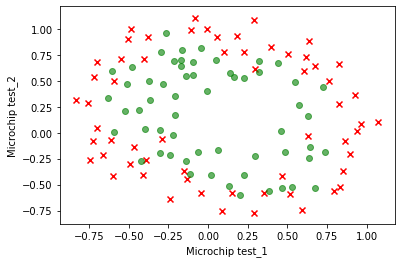

In [0]:
plotData(X, y)

###Feature mapping

In [0]:
degree = 14

In [0]:
def featureMap(X1, X2, degree):
  X_out = []
  for i in range (1, degree+1):
    for j in range (i+1):
      tempo = (X1.pow(i-j)*X2.pow(j))
      X_out.append(tempo)
  X_out = torch.stack(X_out)
  return X_out.t()

In [0]:
# Applying feature mapping to our data set
X_out = featureMap(X[:, 0], X[:,1], degree)

In [0]:
def cost_fn(a, y, w, Lambda):
  m = y.numel()
  J = (-1/m) * ((y.t() @ torch.log(a) + (1 - y).t() @ torch.log(1 - a))) + (Lambda/(2*m) * w@w.t())
  
  return J

In [0]:
def backward(X, a, y, w, Lambda):
  m = y.numel()
  dw = 1/m * ((a - y).t() @ X) + (Lambda * (1/m) * w)
  db = 1/m * (a - y).sum()

  return dw, db 


###Helper functions

In [0]:
def sigmoid(z):
  s = 1/(1+torch.exp(-z))
  return s

In [0]:
def initialize_with_zeros(dim):
  w = torch.zeros((1, dim))
  b = torch.tensor([0.0])
  
  assert(w.shape == (1, dim))
    
  return w, b

In [0]:
def model(X, w, b):
  z = X@w.t() + b
  return sigmoid(z)

In [0]:
# zGeneration function calculates predictions for each point of (xx, yy) meshgrid.
def zGeneration(x, y, w, b, degree):  
  assert x.shape == y.shape  
  z = torch.zeros_like(x)
  
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      z[i,j] = featureMap(x[i,j], y[i,j], degree)@w.t() + b
      
  return z

In [0]:
def zGenerationV(x, y, w, b, degree): 
  assert x.shape == y.shape
  x.flatten()
  y.flatten() 
  m = featureMap(x,y,degree)
  z= m@w.t() + b 

  return z  

#I needed to convert the matrix to a vector, as the featureMap function admits only vectors and scalars.   

In [0]:
def plot_decision_boundary(X):
  step = 0.05

  x_min, x_max = torch.min(X[:,0])-1, torch.max(X[:,0])+1
  y_min, y_max = torch.min(X[:,1])-1, torch.max(X[:,1])+1

  xRange = torch.arange(x_min, x_max, step)
  yRange = torch.arange(y_min, y_max, step)

  xx, yy = torch.meshgrid(xRange, yRange)

  zz = zGeneration(xx, yy, w, b, degree)

  plt.scatter(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], marker = 'x', color = 'red', label="Rejected")
  plt.scatter(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], marker = 'o', color = 'green', alpha = 0.6, label="Admitted")
  ax = plt.gca() # gets the current Axes instance on the current figure
  ax.autoscale(False)
  plt.contour(xx, yy, zz, levels = [0])
  plt.legend(loc = 0)

###Training the model

In [0]:
lr = 0.05
epochs = 300000

In [0]:
def train (X, y, lr, epochs, Lambda = 0):
  m = y.numel()
  
  J_history = []
  
  w, b = initialize_with_zeros(X.shape[1])

  for i in range(epochs):
    a = model(X, w, b)  
    J = cost_fn(a, y, w, Lambda)
    dw, db = backward(X, a, y, w, Lambda)
    w -= lr*dw
    b -= lr*db
    
    # Recording the costs
    if i % 100 == 0:
      J_history.append(J) 
      
  return w, b, J_history 

In [0]:
w, b, J_h = train(X_out, y, lr, epochs)

###Plotting the historical values of the cost function J

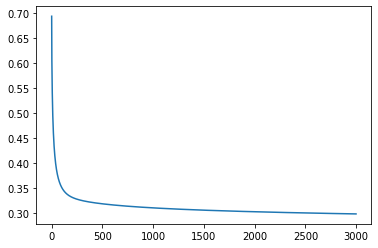

In [0]:
plt.plot(J_h)

###Checking the accuracy of the model

In [0]:
def predict(X, w, b):
  preds = X@w.t() + b
  return preds > 0

In [0]:
y_preds = predict(X_out, w, b).float()

In [0]:
print("train accuracy: {} %".format(100 - torch.mean(torch.abs(y_preds - y)) * 100))

train accuracy: 85.59322357177734 %


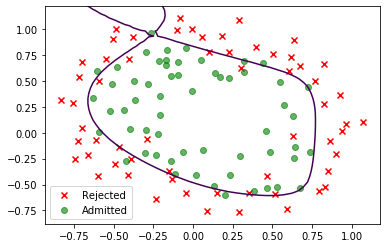

In [0]:
plot_decision_boundary(X)

##Applying regularization


In [0]:
lr = 0.06
epochs = 50000
Lambda = 0.7

In [0]:
w, b, J_h = train(X_out, y, lr, epochs, Lambda)

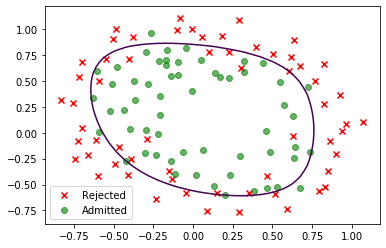

In [0]:
plot_decision_boundary(X)

I have tried dozens of differnt values for the learning rate, epochs and degree hyperparameters and the best accuracy I could get is ~85.6%,
given the fact that I did not want to increase the number of epochs even further. Once I decrease the number of epochs to <=100000 accuracy decreases by ~2%. 
I do relize the number for epochs hyperparameter is pretty high already; however, I could not get the graph looking this way bu using low numbers for epochs. 
Of course I could get better accuracy if I increased the number of epochs to several hundreds of thousands or the degrees to numbers close to 100; however the computation time would have increased correspondingly.
Thus I preferred to keep the numbers as close to reasonable ones for hyperparameters to still get a good accuracy. 